<a href="https://githubtocolab.com/lucarezzonico/Colab-GUI/blob/main/GUI_DLAV_TP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

## Convolutional Networks

We'll check out how to build a **convolutional network** to classify CIFAR10 images. By using weight sharing - multiple units with the same weights - convolutional layers are able to learn repeated patterns in your data. For example, a unit could learn the pattern for an eye, or a face, or lower level features like edges.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


def plot_images(images, cls_true, cls_pred=None):
    """
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


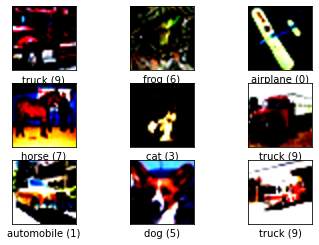

torch.Size([9, 3, 32, 32])


In [ ]:
def get_train_valid_loader(data_dir='data',
                           batch_size=64,
                           augment=False,
                           random_seed = 1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=True,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

        print(np.shape(images))

    return (train_loader, valid_loader)

trainloader, valloader = get_train_valid_loader()

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=3, n_output=10):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        # size of input = [64 x 3 x 32 x 32]

        self.conv1 = nn.Conv2d(in_channels=n_input_channels, out_channels=32, kernel_size=5, stride=1, padding=0, dilation=1)  # w1 = (32 x 3 x 5 x 5), b1 = (32 x 1)
        self.bn1 = nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0, dilation=1) # w2 = (64 x 32 x 5 x 5), b2 = (64 x 1)
        self.bn2 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1)
        self.fc1 = nn.Linear(in_features=64 * 5 * 5, out_features=1200)
        self.fc2 = nn.Linear(in_features=1200, out_features=n_output)
      
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Tensor `x` with `x.view`.                                                    #
        ################################################################################
        
        # x = (64 x 3 x 32 x 32)
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = self.bn1(x)
        # conv1 => x = (64 x 32 x 28 x 28), max_pool2d => x = (64 x 32 x 14 x 14), relu => x = (64 x 32 x 14 x 14)
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = self.bn2(x)
        # conv2 => x = (64 x 64 x 10 x 10), max_pool2d => x = (64 x 64 x 5 x 5), relu => x = (64 x 64 x 5 x 5)
        x = F.relu(self.fc1(x.view(-1, 64 * 5 * 5)))
        # view => x = (64 x 1600), fc1 => x = (64 x 1200), relu => x = (64 x 1200)
        x = self.fc2(x)
        # fc2 => x = (64 x 10)

        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        return x
    
    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)

In [ ]:
def overfit_try():
  # Try to overfit one batch of the training set
  net = ConvNet()

  criterion = torch.nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=1e-1)

  # get one batch of the training set
  data_iter = iter(trainloader)
  images, labels = data_iter.next()

  epochs = 15
  for e in range(epochs):
      optimizer.zero_grad()
      output = net(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()

      # Compute the accuracy on the validation set to compare
      total = 0
      correct = 0
      for ii, (images_val, labels_val) in enumerate(valloader):
          outputs = net(images_val)
          _, predicted = torch.max(F.softmax(outputs).data, 1)

          total += labels_val.size(0)                       # Total images
          correct += (predicted == labels_val).sum().item() # Total correct classified images
      accuracy = 100*correct/total     # accuracy over the images of the validation set

      # Compute the accuracy on the training set
      _, predicted_train = torch.max(F.softmax(output).data, 1)
      total_train = labels.size(0)                             # Total images
      correct_train = (predicted_train == labels).sum().item() # Total correct classified images
      accuracy_train = 100*correct_train/total_train

      print("Epoch: {}/{}..".format(e+1, epochs),
            "Training accuracy: {:.2f}%..".format(accuracy_train),
            "Validation accuracy: {:.2f}%..".format(accuracy)
          )
      
overfit_try()

**Training**

In [ ]:
def train_model(learning_rate_start, print_every, epochs, lambda_l2, lambda_l1):
  net = ConvNet()
  ################################################################################
  # TODO:                                                                        #
  # Choose an Optimizer that will be used to minimize the loss function.         #
  # Choose a critera that measures the loss                                      #
  ################################################################################

  criterion = torch.nn.CrossEntropyLoss()
  # learning_rate_start = 0.1

  # epochs = 5
  steps = 0         
  # print_every = 20

  # coefficients for regularization using L2 and L1 penalty
  # lambda_l2 = 0.005 # 0, 0.001, 0.005, 0.01
  # lambda_l1 = 0.0   # 0.000001, 0.000005, 0.00001 

  # store loss and accuracy for training and validation set
  loss_history_training = []
  loss_history_validation = []
  accuracy_history_training = []
  accuracy_history_validation = []
  running_loss_training = 0
  running_loss_validation = 0
  total_training = 0
  correct_training = 0
  total_validation = 0
  correct_validation = 0

  # configure learning rate decay
  optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate_start)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.4)

  # go through the training set e times
  for e in range(epochs):
      print("\n lr = {:e}:".format(scheduler.get_last_lr()[0]))
      start = time.time()
      for images, labels in iter(trainloader):
          
          steps += 1
          ################################################################################
          # TODO:                                                                        #
          # Run the training process                                                     #
          #                                                                              #
          #                                                                              #
          ################################################################################
          
          optimizer.zero_grad() # set the gradient of the parameters to zero through the optimizer
          output = net(images)

          _, predicted_training = torch.max(F.softmax(output).data, 1)

          # update variables for accuracy on training set
          total_training += labels.size(0)                                # Total images
          correct_training += (predicted_training == labels).sum().item() # Total correct classified images

          ################################################################################
          #                              END OF YOUR CODE                                #
          ################################################################################
          
          loss = criterion(output, labels)
          ################################################################################
          # TODO:                                                                        #
          # Run the training process                                                     #
          #                                                                              #
          # HINT: Calculate the gradient and move one step further                       #
          ################################################################################
                  
          # L2 penalty term (to avoid overfitting the training data for an increasing number of epochs)
          for p in net.parameters():
              loss += lambda_l2 * p.pow(2).sum()

          loss.backward()
          optimizer.step()

          # L1 penalty (directly changes the parameters in the network)
          with torch.no_grad():
              for p in net.parameters():
                  p.sub_(p.sign() * p.abs().clamp(max = lambda_l1))

          ################################################################################
          #                              END OF YOUR CODE                                #
          ################################################################################
          
          running_loss_training += loss.item()

          if steps % print_every == 0:
              stop = time.time()
              # reset training and validation accuracy after print_every iterations
              accuracy_training = 0
              accuracy_validation = 0
              for ii, (images, labels) in enumerate(valloader):
                  
                  ################################################################################
                  # TODO:                                                                        #
                  # Calculate the accuracy                                                       #
                  ################################################################################
                  
                  outputs = net(images)
                  _, predicted_validation = torch.max(F.softmax(outputs).data, 1)

                  # Loss for validation set
                  loss_validation = criterion(outputs, labels)

                  # L2 penalty term
                  for p in net.parameters():
                      loss_validation += lambda_l2 * p.pow(2).sum()
                  
                  running_loss_validation += loss_validation.item()

                  # update variables for accuracy on validation set
                  total_validation += labels.size(0)                                  # Total images
                  correct_validation += (predicted_validation == labels).sum().item() # Total correct classified images

              # compute accuracy for training and validation set
              accuracy_training = 100*correct_training/total_training
              accuracy_validation = 100*correct_validation/total_validation
              
              # store loss and accuracy for training and validation set
              loss_history_training.append(running_loss_training/print_every) # mean loss on training set over print_every iterations
              loss_history_validation.append(running_loss_validation/(ii+1))  # mean loss on validtion set, updated all print_every iterations
              accuracy_history_training.append(accuracy_training)
              accuracy_history_validation.append(accuracy_validation)

              ################################################################################
              #                              END OF YOUR CODE                                #
              ################################################################################
              
              print("Epoch: {}/{}..".format(e+1, epochs),
                    "Training Loss: {:.4f}..".format(running_loss_training/print_every),
                    "Validation Loss: {:.4f}..".format(running_loss_validation/(ii+1)),
                    "Training accuracy: {:.2f}%..".format(accuracy_training),
                    "Validation accuracy: {:.2f}%..".format(accuracy_validation),            # accuracy over the images of the validation set
                    "{:.4f} s/batch".format((stop - start)/print_every)
                  )
              # reset variables for training and validation loss after print_every iterations
              running_loss_training = 0
              running_loss_validation = 0
              # reset variables for training and validation accuracy after print_every iterations
              total_training = 0
              correct_training = 0
              total_validation = 0
              correct_validation = 0

              start = time.time()

      # decrease learning rate
      scheduler.step()

  return net, loss_history_training, loss_history_validation, accuracy_history_training, accuracy_history_validation


In [ ]:
#@title Training Parameters
#@markdown Learning Rate for the first epoch:
learning_rate_start = 0.1 #@param {type:"number"}
#@markdown Number of epochs:
epochs = 5        #@param {type:"number"}
#@markdown L2 regularization coefficient:
lambda_l2 = 0.005 #@param {type:"number"} # 0, 0.001, 0.005, 0.01
#@markdown L1 regularization coefficient:
lambda_l1 = 0.0   #@param {type:"number"} # 0.000001, 0.000005, 0.00001 
#@markdown Run Model validation every "print_every" iteration:
print_every = 20  #@param {type:"number"}

net, loss_history_training, loss_history_validation, accuracy_history_training, accuracy_history_validation = train_model(learning_rate_start, print_every, epochs, lambda_l2, lambda_l1)

Epoch: 5/5.. Training Loss: 1.1414.. Validation Loss: 1.2368.. Training accuracy: 78.28%.. Validation accuracy: 73.40%.. 0.1412 s/batch


**Plots**

In [ ]:
def plot_performance(plot_option, loss_history_training, loss_history_validation, accuracy_history_training, accuracy_history_validation, print_every):
  # Plot settings
  plt.rcParams['figure.figsize'] = [5, 3]
  plt.rcParams['figure.dpi'] = 120

  if plot_option == "Loss":
    training_performance = loss_history_training
    validation_performance = loss_history_validation
    Y_LABEL = "Loss"
    TITLE = "Training & Validation Loss"
  elif plot_option == "Accuracy":
    training_performance = accuracy_history_training
    validation_performance = accuracy_history_validation
    Y_LABEL = "Accuracy [%]"
    TITLE = "Training & Validation Accuracy"

  # Plotting the loss history for different learning rates
  plt.plot((np.arange(np.shape(training_performance)[0])+1)*print_every, training_performance, label='Training')
  plt.plot((np.arange(np.shape(validation_performance)[0])+1)*print_every, validation_performance, label='Validation')
  plt.xlabel("Iteration")
  plt.ylabel(Y_LABEL)
  plt.title(TITLE)
  plt.legend(bbox_to_anchor = (1, 1))
  plt.grid()
  plt.show() # Load the display window


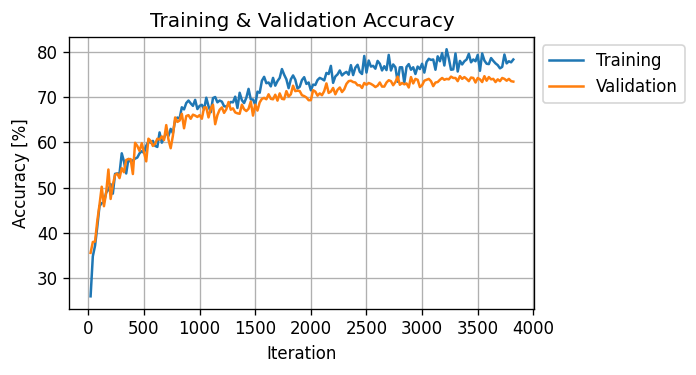

In [ ]:
#@title Plot Loss or Accuracy { run: "auto" }
plot_option = "Accuracy" #@param ["Loss", "Accuracy"]
plot_performance(plot_option, loss_history_training, loss_history_validation, accuracy_history_training, accuracy_history_validation, print_every)


**Save best trained model.**

In [ ]:
## You should be familiar with how to save a pytorch model (Make sure to save the model in your Drive)
#@title Save Model to:
model_save_directory = 'drive/MyDrive/Colab Notebooks/Colab-GUI/ConvNN.ckpt' #@param {type:"string"}
torch.save(net.state_dict(), model_save_directory)

In [ ]:
#@title Load Model from:
model_load_directory = "drive/MyDrive/Colab Notebooks/Colab-GUI/ConvNN.ckpt" #@param {type:"string"}
checkpoint = torch.load(model_load_directory)
net.load_state_dict(checkpoint)

<All keys matched successfully>